In [ ]:
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import FRED
if torch.__version__[:4] == '1.13': # If using pytorch with MPS, use Apple silicon GPU acceleration
    device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.has_mps else "cpu")
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# sns.set_theme()
%load_ext autoreload
%autoreload 2

Using device cpu


# 05b Toy Dataset Benchmarker
> Run a given model on all of our toy datasets (optionally, do so many times), and produce training gifs and loss charts for each.

This is set up for the popular library `papermill`, which can parameterize and execute notebooks. 

First, we set the notebook-wide parameters, then run the cells. Papermill will create copies of the notebook with each parameter configuration given.

In [ ]:
name_of_test = "double_helix"
dataset_name = "double helix"
# embedding parameters
sigma = 1
flow_strength = 1 
# weights
smoothness_weight = 0
flow_neighbor_loss_weight = 1
diffdist_weight = 1
num_neighbors = 10

In [ ]:
# Parameters
name_of_test = "double_helix_benchmark"
dataset_name = "double helix"
sigma = 0.5
flow_strength = 0.5
smoothness_weight = 0
flow_neighbor_loss_weight = 0.1
diffdist_weight = 10
num_neighbors = 10


# Set Up

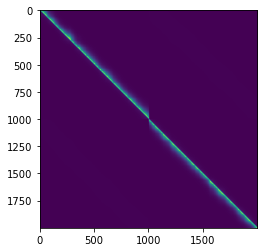

In [ ]:
from FRED.datasets import double_helix, directed_swiss_roll_delayed, directed_sinh_branch
from FRED.data_processing import dataloader_from_ndarray, ManifoldWithVectorField
from torch.utils.data import DataLoader
# choose correct dataset
if dataset_name == "double helix":
    X, flow, labels = double_helix(num_nodes=2000)
elif dataset_name == "branch":
    X, flow, labels = directed_sinh_branch(num_nodes=2000)
# build dataset
ds = ManifoldWithVectorField(X, flow, labels, sigma=sigma, dmap_coords_to_use=3, nbhd_strategy="flow neighbors", n_neighbors=num_neighbors, flow_strength = flow_strength)
dataloader = DataLoader(ds, batch_size=None, shuffle=True)

## Set up the model

In [ ]:
# initialize model parameters and layers
from FRED.embed import ManifoldFlowEmbedder
from FRED.trainers import save_embedding_visualization, visualize_points, Trainer
title = name_of_test
MFE = ManifoldFlowEmbedder(
            embedding_dimension=2,
            embedder_shape=[3, 4, 8, 4, 2],
            device=device,
            sigma=0.5,
            flow_strength=0.5,
            smoothness_grid=True,
        )
loss_weights = {
            "reconstruction": 0,
            "diffusion map regularization": diffdist_weight,
            "kld": 0,
            "smoothness": smoothness_weight,
            "flow neighbor loss": flow_neighbor_loss_weight,
        }
visualization_functions = [
    save_embedding_visualization # just save these, for use in gif making. No visualizations otherwise, to keep it tidy.
]
FREDtrainer = Trainer(FE = MFE, loss_weights=loss_weights, visualization_functions = visualization_functions, device=device, title = title)

In [ ]:
#papermill_description=FittingFRED
FREDtrainer.fit(dataloader, n_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

# Results

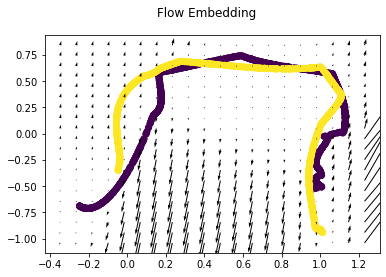

In [ ]:
FREDtrainer.visualize_embedding()

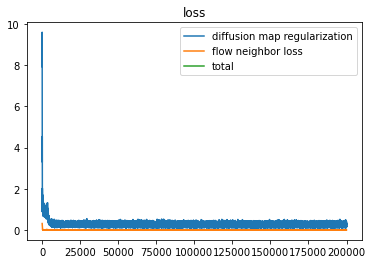

In [ ]:
FREDtrainer.visualize_loss()

# Qualitative analyses

In [ ]:
import sklearn 
silhouette = sklearn.metrics.silhouette_score(X, labels)

In [ ]:
print(f"## SCORES ## \n silhouette score: {silhouette} \n")

## SCORES ## 
 silhouette score: 0.024469633113813904 

